# Setup and import data

In [20]:
#import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
#import arviz as az
from datetime import datetime
import multiprocessing as mp
import matplotlib.cm as cm
import time
from scipy.stats import linregress
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')

In [22]:
out = pd.read_pickle('data/vendimia/results_short_days_314-335.pkl')

In [23]:
out[:5]

pdv    mycup  left_in_stock  expected_purchase_mean  \
0     151872   629792     -13.948677               17.098677   
1  209980329   548516      -4.503336                6.477836   
2     151872   766115     -11.113564               14.322314   
3     151912  4027740      -4.943248                9.713860   
4     151872  4027740      -4.562465                9.345501   

   relative_expected_purchase_mean  significance  \
0                         5.428151    424.820048   
1                         3.280748    392.596150   
2                         4.463518    254.744743   
3                         2.036187    239.405749   
4                         1.953885    186.132524   

   rate_parameters_to_datapoints     error  
0                       3.238298  0.320776  
1                       7.012806  0.570671  
2                       1.053672  0.354959  
3                       2.447867  0.470291  
4                       2.447867  0.685113

In [24]:
filename = '20241211-rosario-full.csv' # See query to get this file above
dir = 'data/vendimia/'
mydatatest0 = pd.read_csv(dir+filename)
mydatatest0 = mydatatest0[(mydatatest0['ANIO'] == 2024) & (mydatatest0['KILOS'] > 0) & (mydatatest0['DISTRIBUIDOR'] == 'LA VENDIMIA S.RL.')]
mydatatest = mydatatest0[mydatatest0['FECHA'] >= '2024-11-16']
#mydatatest = mydatatest[mydatatest['CANAL'] == 'Maxi Kiosco']
mydatatest.reset_index(inplace=True, drop=True)

In [25]:
mydatatest[:5]

PDVID   SKUID  VENTA_NETA     KILOS  LITROS                FECHA  ANIO  \
0     150063  176388     6935.54  0.200000     NaN  2024-12-06 00:00:00  2024   
1    3919240  180732     5553.72  0.714000     NaN  2024-12-06 00:00:00  2024   
2     150173  146227     2874.48  0.244000     NaN  2024-12-06 00:00:00  2024   
3  213440402  146227     2155.86  0.183000     NaN  2024-12-06 00:00:00  2024   
4     148824  180789     5857.89  0.335833     NaN  2024-12-06 00:00:00  2024   

   SEMANA  DIA JEFATURA           CANAL       DISTRIBUIDOR  CUP_SAP_CODE  \
0      49    5  ROSARIO  Kiosco Ventana  LA VENDIMIA S.RL.        660279   
1      49    5  ROSARIO  Kiosco Ventana  LA VENDIMIA S.RL.        658956   
2      49    5  ROSARIO   Tradicionales  LA VENDIMIA S.RL.        660487   
3      49    5  ROSARIO   Tradicionales  LA VENDIMIA S.RL.        660487   
4      49    5  ROSARIO  Kiosco Ventana  LA VENDIMIA S.RL.        920539   

    CATEGORIA  SUBCATEGORIA SEGMENTO  
0        Gums       Adultos  Regular  
1    Biscuits  Dulces Secas  Regular  
2  Chocolates     Alfajores  Triples  
3  Chocolates     Alfajores  Triples  
4     Candies       Adultos  Regular

## Compare Estimations Vs Results

In [26]:
# We construct lists that contain the predicted purchase and the actual purchase
# We separate into different lists according to the threshold in the error
# We only include cases where the purchase was made !
expected_purchase_mean = 0
mylist = []  # all
mylist2 = [] # error < 2
mylist1 = [] # error < 1
mylist05 = []# error < 0.5
r = 0 # threshold rate for parameters to datapoints, one can play with this.  In principle expect larger r to behave better
for i in range(len(mydatatest)):
    pdv, kilos_true, cup = mydatatest.iloc[i][[0, 3, 12]]
    try:
        expected_purchase_mean = out[(out['pdv']==pdv) & (out['mycup']==cup) & (out['error'] < 2) & (out['rate_parameters_to_datapoints'] > r)]['expected_purchase_mean'].values[0]
    except: 
        pass

    if expected_purchase_mean > 0: 
        try:
            tmp = out[(out['pdv']==pdv) & (out['mycup']==cup) & (out['error'] > -1) & (out['rate_parameters_to_datapoints'] > r)]['significance'].values[0]
            mylist.append([pdv,cup,tmp,kilos_true, expected_purchase_mean])
        except:
            pass
        try:
            tmp = out[(out['pdv']==pdv) & (out['mycup']==cup) & (out['error'] < 1) & (out['rate_parameters_to_datapoints'] > r)]['significance'].values[0]
            mylist1.append([pdv,cup,tmp,kilos_true, expected_purchase_mean])
        except:
            pass
        try:
            tmp = out[(out['pdv']==pdv) & (out['mycup']==cup) & (out['error'] < 0.5) & (out['rate_parameters_to_datapoints'] > r)]['significance'].values[0]
            mylist05.append([pdv,cup,tmp, kilos_true, expected_purchase_mean])
        except:
            pass
        try:
            tmp = out[(out['pdv']==pdv) & (out['mycup']==cup) & (out['error'] < 2) & (out['rate_parameters_to_datapoints'] > r)]['significance'].values[0]
            mylist2.append([pdv,cup,tmp, kilos_true, expected_purchase_mean])
        except:
            pass        

/tmp/ipykernel_30277/1280504460.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pdv, kilos_true, cup = mydatatest.iloc[i][[0, 3, 12]]


In [27]:
l05 = len(mylist05)
l1 = len(mylist1)
l2 = len(mylist2)
l = len(mylist)

#### Let's test how well the KILOS are estimated

In [28]:
# Fit line to the data for each selection according to the error
a = [x[3] for x in mylist]
b = [x[4] for x in mylist]
s = linregress(a, b,)

a = [x[3] for x in mylist2]
b = [x[4] for x in mylist2]
s2 = linregress(a, b)

a = [x[3] for x in mylist1]
b = [x[4] for x in mylist1]
s1 = linregress(a, b)

a = [x[3] for x in mylist05]
b = [x[4] for x in mylist05]
s05 = linregress(a, b)

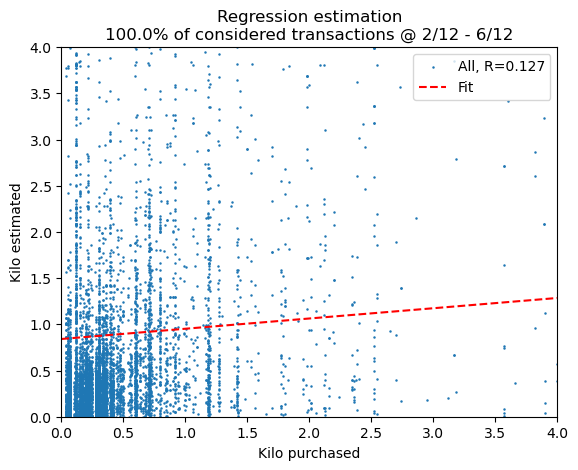

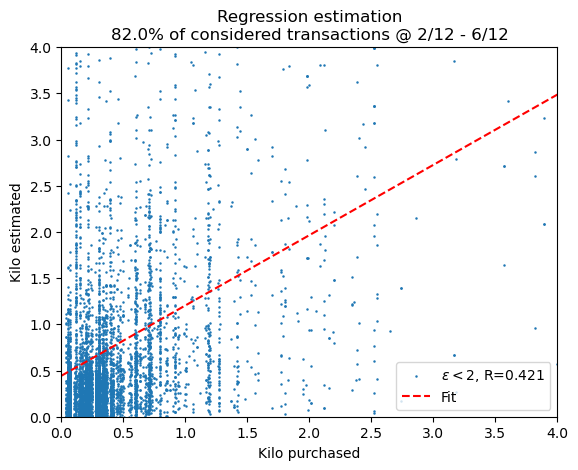

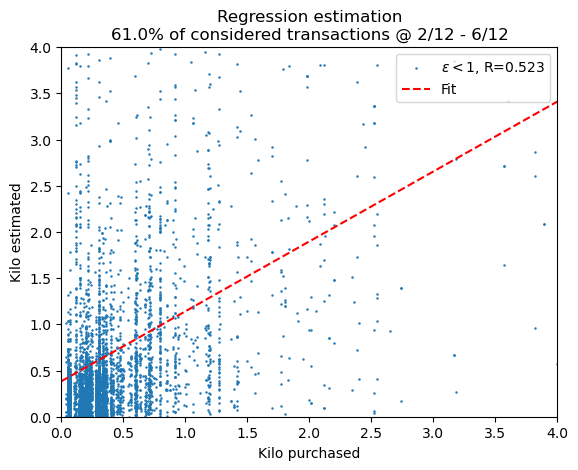

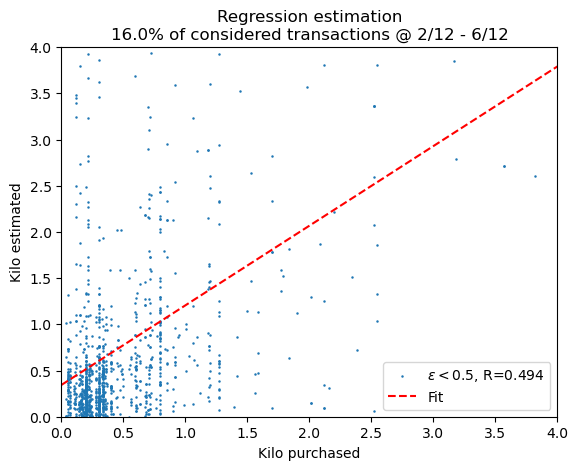

In [31]:
# Let's plot predicted vs true and visualy get the grasp of what's going on´
x = np.linspace(0,4,100)
dates = '2/12 - 6/12'
plt.scatter([x[3] for x in mylist], [x[4] for x in mylist], s=0.6, label='All, R='+str(round(s[2],3)))
plt.plot(x, s[0]*x + s[1], 'r--', label='Fit')
plt.xlim(0,4)
plt.ylim(0,4)
plt.title('Regression estimation\n'+str(100 *l/l)+'% of considered transactions @ '+dates)
plt.xlabel('Kilo purchased')
plt.ylabel('Kilo estimated')
plt.legend()
plt.show()

plt.scatter([x[3] for x in mylist2], [x[4] for x in mylist2], s=0.6, label='$\epsilon<2$, R='+str(round(s2[2],3)))
plt.plot(x, s2[0]*x + s2[1], 'r--', label='Fit')
plt.xlim(0,4)
plt.ylim(0,4)
plt.title('Regression estimation\n'+str(100* np.round(l2/l,2))+'% of considered transactions @ '+dates)
plt.xlabel('Kilo purchased')
plt.ylabel('Kilo estimated')
plt.legend()
plt.show()


plt.scatter([x[3] for x in mylist1], [x[4] for x in mylist1], s=0.6, label='$\epsilon<1$, R='+str(round(s1[2],3)))
plt.plot(x, s1[0]*x + s1[1], 'r--', label='Fit')
plt.xlim(0,4)
plt.ylim(0,4)
plt.title('Regression estimation\n'+str(100* np.round(l1/l,2))+'% of considered transactions @ '+dates)
plt.xlabel('Kilo purchased')
plt.ylabel('Kilo estimated')
plt.legend()
plt.show()


plt.scatter([x[3] for x in mylist05], [x[4] for x in mylist05], s=0.6, label='$\epsilon<0.5$, R='+str(round(s05[2],3)))
plt.plot(x, s05[0]*x + s05[1], 'r--', label='Fit')
plt.xlim(0,4)
plt.ylim(0,4)
plt.title('Regression estimation\n'+str(100* np.round(l05/l,2))+'% of considered transactions @ '+dates)
plt.xlabel('Kilo purchased')
plt.ylabel('Kilo estimated')
plt.legend()
plt.show()